In [1]:
# Cell 1: Imports & project-root setup
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

from common.config import DEVICE
from models.autoencoder.dataset_autoencoder import DatasetAutoencoder
from models.autoencoder.utils import split_dataset
from models.autoencoder.architectures.flexible_autoencoder import ConvAutoencoder

config.py: DEVICE is set as cuda


In [2]:
# Cell 2: Key constants (EDIT THESE AS NEEDED)
DATA_PATH       = "data/waveforms"
MARKER_DIR      = "artifacts"
REDUCTION       = "resample"
REDUCTION_N     = 200
TRAIN_FRAC      = 0.8
SEED            = 42
BATCH_SIZE      = 50
LATENT_DIM      = 32
DROPOUT         = 0.0
USE_BATCHNORM   = True
LEARNING_RATE   = 1e-3

CKPT_DIR        = PROJECT_ROOT / "artifacts" / "autoencoder" / "checkpoints"
CKPT_FILENAME   = "ConvAE_resample200_lat32_bn_2025-06-17_16-08-45.pt"
CKPT_PATH       = CKPT_DIR / CKPT_FILENAME

PLOTS_DIR       = PROJECT_ROOT / "results" / "autoencoder" / "Resample200, Lat32, BN, Adam, MSE, 500e, 2025-06-17_16-08-45"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

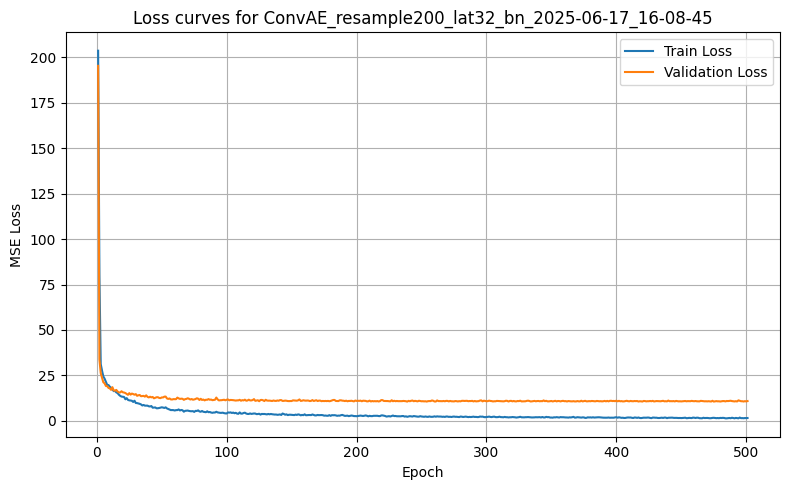

In [3]:
# Cell 3: Plot training & validation loss curves
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
history    = ckpt.get("history", {})
train_loss = history.get("train_loss")
val_loss   = history.get("val_loss")

epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs,   val_loss,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Loss curves for {ckpt.get('run_name','<run>')}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "loss_curves.png")
plt.show()

In [4]:
# Cell 4: Setup — dataset, val_set, val_loader, model (only once)
dataset = DatasetAutoencoder(
    path=DATA_PATH,
    reduction=REDUCTION,
    n=REDUCTION_N,
    save=False,
    force_reload=False
)
_, val_set = split_dataset(dataset, train_frac=TRAIN_FRAC, seed=SEED)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

model = ConvAutoencoder(
    dataset=dataset,
    latent_dim=LATENT_DIM,
    dropout=DROPOUT,
    use_batchnorm=USE_BATCHNORM,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    train_frac=TRAIN_FRAC,
    seed=SEED,
    reduction=REDUCTION,
    reduction_n=REDUCTION_N,
    timestamp=False
).to(DEVICE)

chk = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(chk['state_dict'])
model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(15,), stride=(5,), padding=(7,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv1d(8, 16, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=320, out_features=1024, bias=True)
    (8): ELU(alpha=1.0)
    (9): Identity()
    (10): Linear(in_features=1024, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1024, out_features=320, bias=True)
    (3): ELU(alpha=1.0)
    (4): Unflatten(dim=1, unflattened_size=(16, 20))
    (5): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (6): BatchNorm1d(8, eps=1e-0

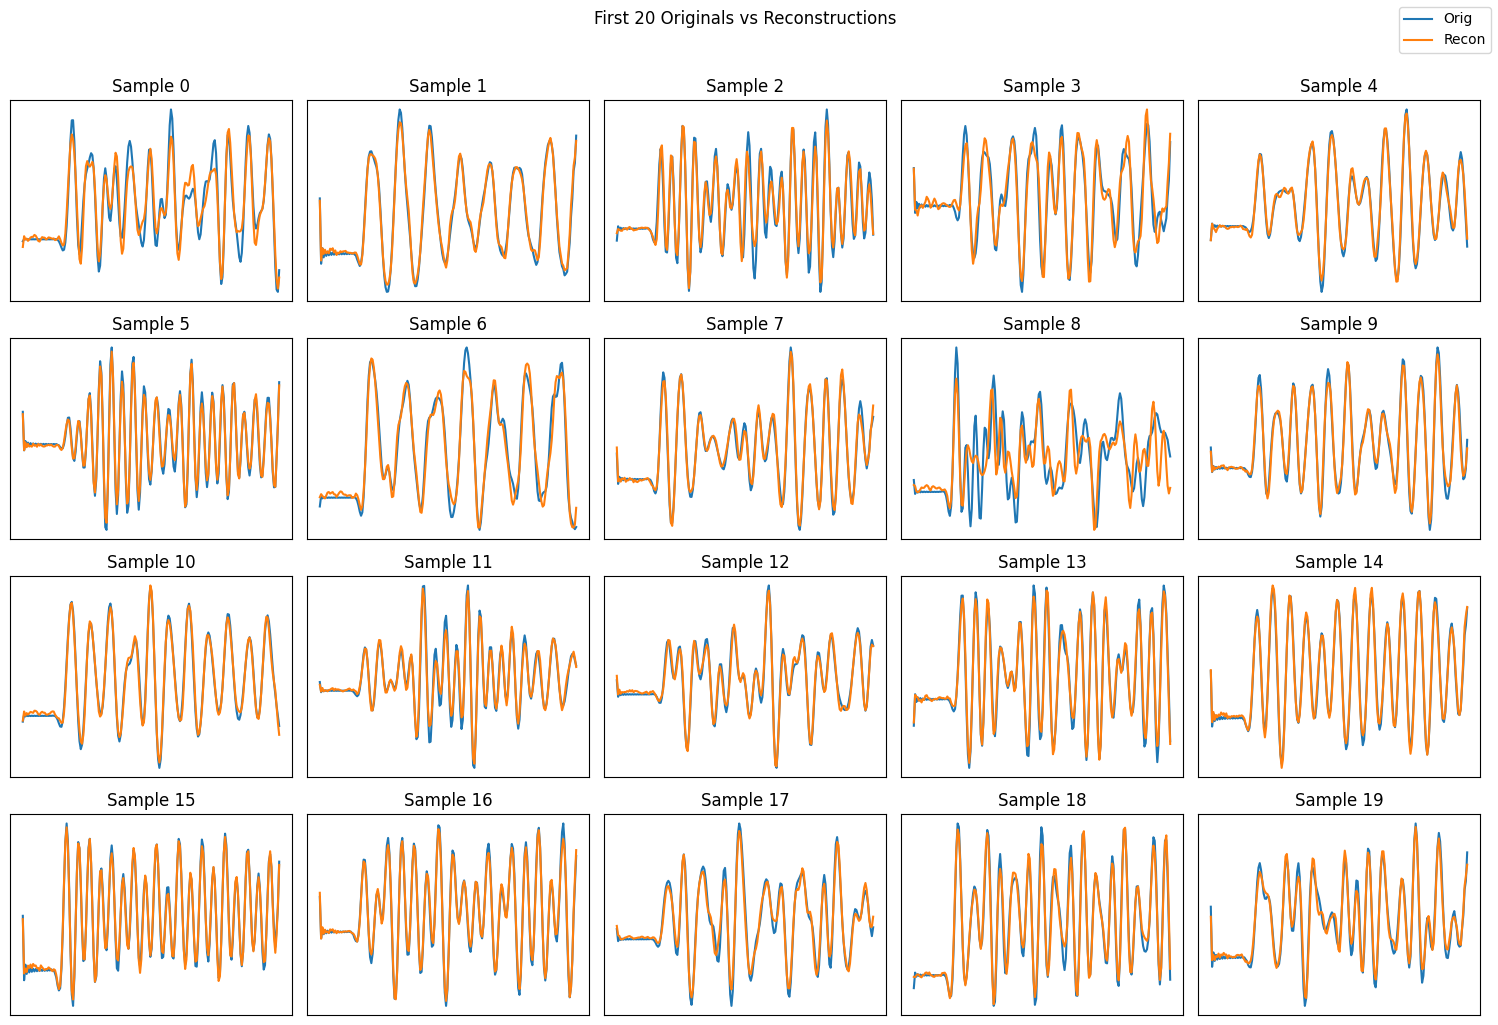

In [5]:
# Cell 5: Plot first 20 originals vs reconstructions
batch = next(iter(torch.utils.data.DataLoader(val_set, batch_size=20, shuffle=False)))
waves = batch.unsqueeze(1).to(DEVICE)

with torch.no_grad():
    recon = model(waves).unsqueeze(1).cpu().numpy()
    orig  = waves.cpu().numpy()

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(orig[i].squeeze(), label='Orig')
    ax.plot(recon[i].squeeze(), label='Recon')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Sample {i}")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.suptitle("First 20 Originals vs Reconstructions", y=1.02)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "first20_recons.png")
plt.show()


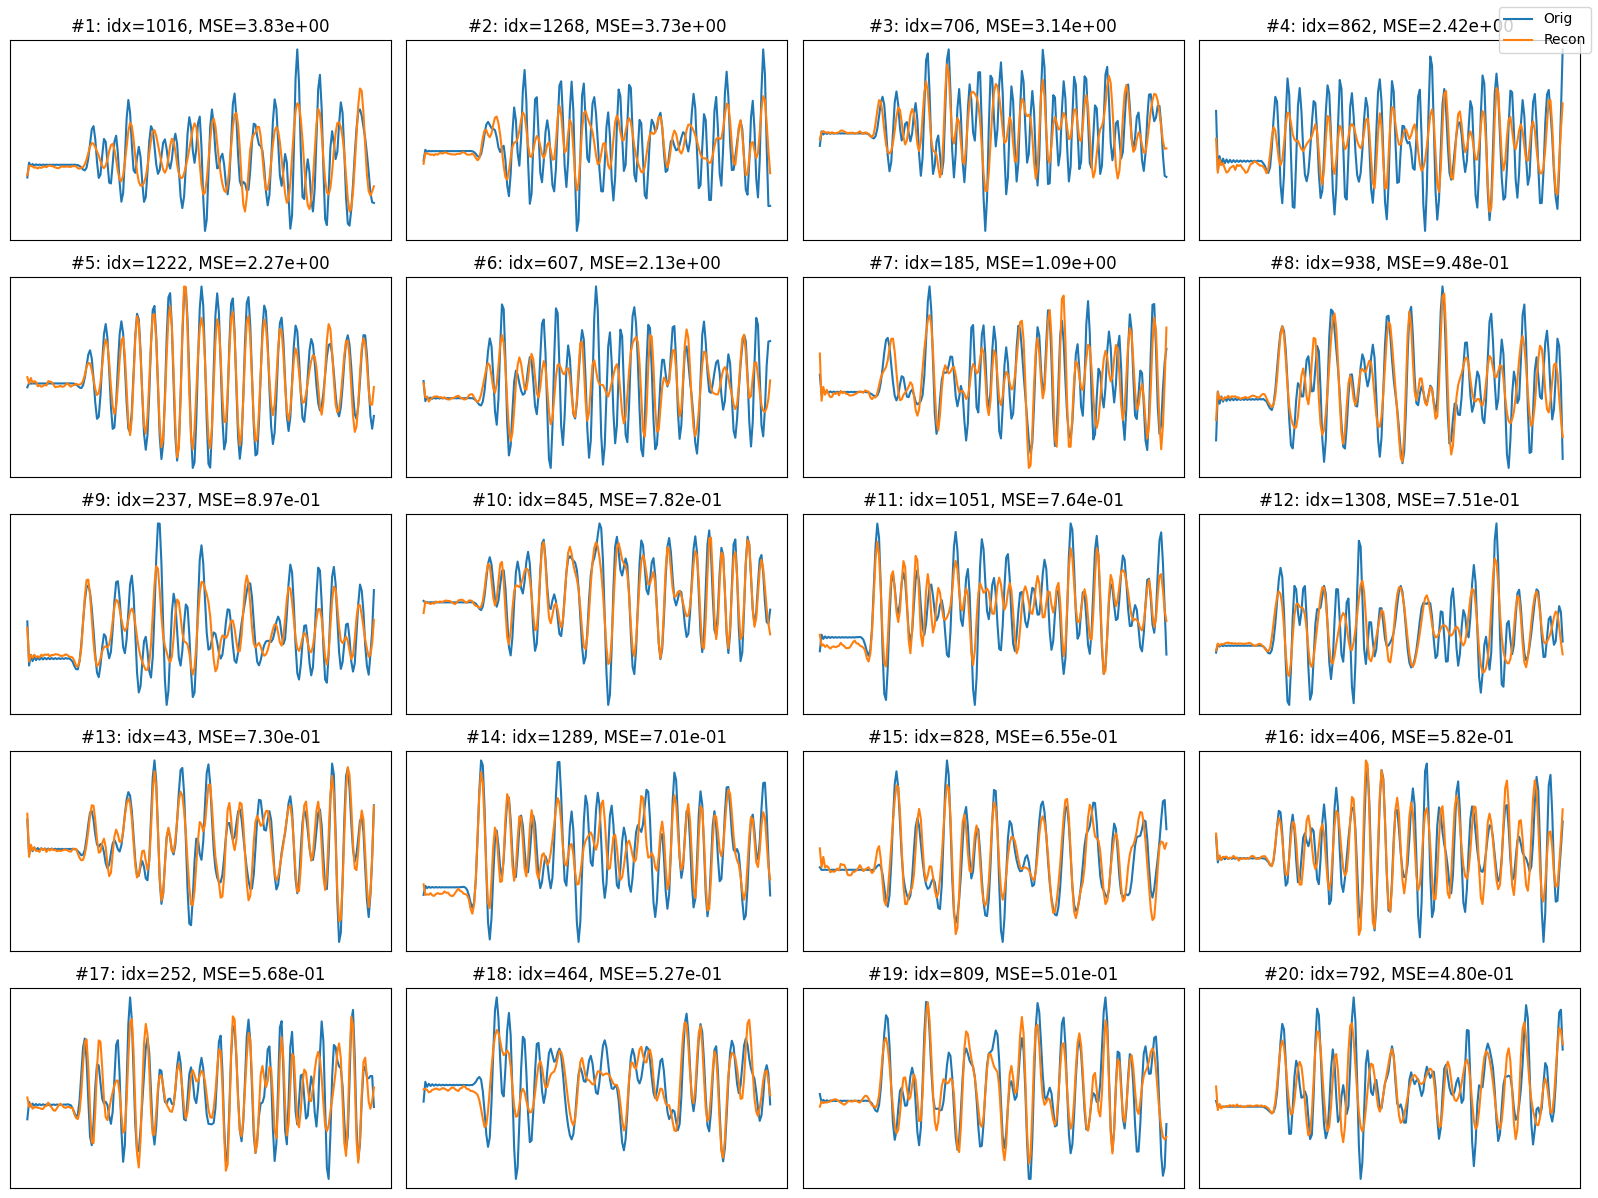

In [6]:
# Cell 6: Compute full-val MSEs and plot top-20 worst reconstructions
all_waves, all_recons, all_mse = [], [], []
with torch.no_grad():
    for batch in val_loader:
        waves = batch.unsqueeze(1).to(DEVICE)
        recon = model(waves).unsqueeze(1).cpu().numpy()
        all_waves.append(waves.cpu().numpy())
        all_recons.append(recon)
        all_mse.append(((recon - waves.cpu().numpy())**2).mean(axis=(1,2)))

all_waves      = np.concatenate(all_waves, axis=0)
all_recons     = np.concatenate(all_recons, axis=0)
mse_per_sample = np.concatenate(all_mse, axis=0)

top20 = np.argsort(mse_per_sample)[-20:][::-1]
fig, axes = plt.subplots(5, 4, figsize=(16,12))
for i, idx in enumerate(top20):
    ax = axes.flatten()[i]
    ax.plot(all_waves[idx].squeeze(), label='Orig')
    ax.plot(all_recons[idx].squeeze(),  label='Recon')
    ax.set_title(f"#{i+1}: idx={idx}, MSE={mse_per_sample[idx]:.2e}")
    ax.set_xticks([]); ax.set_yticks([])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top20_worst_recons.png")
plt.show()



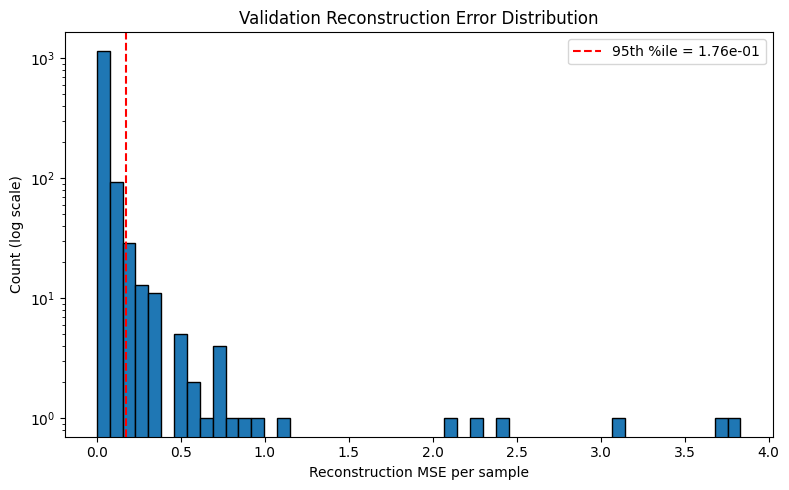

In [7]:
# Cell 5: Histogram of validation-set MSE distribution
plt.figure(figsize=(8,5))
plt.hist(mse_per_sample, bins=50, edgecolor='black', log=True)
plt.xlabel('Reconstruction MSE per sample')
plt.ylabel('Count (log scale)')
plt.title('Validation Reconstruction Error Distribution')
thresh = np.percentile(mse_per_sample, 95)
plt.axvline(thresh, color='red', linestyle='--', label=f'95th %ile = {thresh:.2e}')
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "mse_histogram.png")
plt.show()
